# Saving and retrieving Qiskit objects

Quantum workflows often take a while to complete so must run over many sessions. Restarting your Python kernel means you'll lose any circuits or results stored in memory. To avoid loss of data, you can save quantum circuits to file and retrieve results of past jobs from IBM Quantum so your next session can continue where you left off.

## Saving circuits to file

Use [QPY serialization](/api/qiskit/qpy) to save your circuit to file. QPY files save the full Qiskit circuit object and are forwards-compatible, meaning they'll be understood by newer versions of Qiskit.

To demonstrate, the following cell creates a simple quantum circuit.

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

To save this file to disk, use the `qpy.dump` function. You can also save a list of circuits.

In [2]:
from qiskit import qpy

with open('test.qpy', 'wb') as file:
    qpy.dump(qc, file)

This circuit is now saved to the file `test.qpy`. If you restart your Python kernel, you can re-load the circuit using the `qpy.load` function. Note that this always returns a list of circuits, even if you only serialized one circuit.

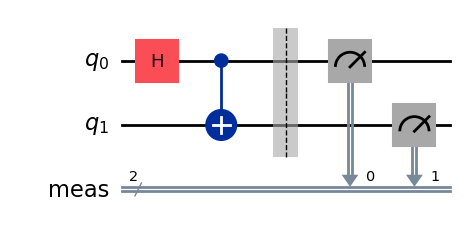

In [3]:
with open('test.qpy', 'rb') as handle:
    qc = qpy.load(handle)

qc[0].draw('mpl')

In [4]:
# Cleanup the file we created (this cell should be hidden from the user)
import pathlib
pathlib.Path('test.qpy').unlink()

## Retrieving jobs from IBM Quantum

IBM Quantum automatically stores results from every job for you to retrieve at a later date. Use this feature to continue quantum programs across kernel restarts and review past results. You can get the ID of a job programatically through its `job_id` method, or you can see all your submitted jobs (and their IDs) at https://quantum.ibm.com/jobs.

To demonstrate, the following cell sets up our Qiskit Runtime service and selects a backend.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, min_num_qubits=2)
sampler = Sampler(backend=backend)

The following cell submits the job and prints its ID.

In [6]:
from qiskit import transpile
job = sampler.run(transpile(qc, backend), shots=10)
my_id = job.job_id()
print(my_id)

co22fda1lo04nv57hjig


/Users/qiskit/.venv/lib/python3.11/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:878: UserWarning: Cloud simulators will be deprecated on 15 May 2024. Use the new local testing mode in qiskit-ibm-runtime version 0.22.0 or later to meet your debugging needs.
  warnings.warn(warning_message)


Now we have the job's ID, we can retrieve it in a different session or at a later date using the `service.job` method.

In [7]:
retrieved_job = service.job(my_id)
retrieved_job.result()

PrimitiveResult([PubResult(data=DataBin<>(meas=BitArray(<shape=(), num_shots=10, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'version': 2})

### Programatically finding jobs

If you don't have a job ID and want to find it programatically rather than visiting https://quantum.ibm.com/jobs, you can use the `QiskitRuntimeService.jobs` method.

The following cell finds any jobs submitted in the last hour. The `created_after` argument must be a [`datetime.datetime`](https://docs.python.org/3.8/library/datetime.html#datetime.datetime) object.

In [8]:
import datetime
one_hour_ago = datetime.datetime.now() - datetime.timedelta(hours=1)

service = QiskitRuntimeService()
service.jobs(created_after=one_hour_ago)

[<RuntimeJob('co22fda1lo04nv57hjig', 'sampler')>,
 <RuntimeJob('cr222mapcdbg008ttrz0', 'sampler')>]

You can also select by backend, job state, session, and more. See the [API documentation](/api/qiskit-ibm-runtime/qiskit_ibm_runtime.QiskitRuntimeService#jobs) for more information.

## Saving results to disk

You may also want to save results to disk. You can use Python's built-in Pickle library to do this. Note that `PrimitiveResult` objects from `qiskit-ibm-runtime` are not directly serializable, so you must serialize parts of them individually.

In [9]:
import pickle
with open("result.pickle", "wb") as file:
    measurements = job.result()[0].data.meas.array
    pickle.dump(measurements, file)

You can then load this array from disk in a separate kernel.

In [10]:
with open("result.pickle", "rb") as file:
    measurements = pickle.load(file)
print(measurements)

[[0]
 [0]
 [3]
 [0]
 [3]
 [3]
 [3]
 [0]
 [0]
 [3]]


In [11]:
# Cleanup the file we created (this cell should be hidden from the user)
pathlib.Path('result.pickle').unlink()